# GTHA housing market database
# OSEMN methodology Step 4: Model
# Classify land use from new features in Teranet (3 classes)
# Top 11 selected features

Top 11 selected features and with missing past/future xy sales filled with mean future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, targets_corr, plot_learning_curve, plot_validation_curve, plot_confusion_matrix

In [185]:
def plot_confusion_matrix(y_true, y_pred, classes, model_name,
                          normalize=False,
                          interpolation='nearest',
                          cmap=plt.cm.Blues,
                          width=4):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = '{0}\nNormalized confusion matrix'.format(model_name)
    else:
        title = '{0}\nConfusion matrix, without normalization'.format(model_name)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("{0}\nNormalized confusion matrix".format(model_name))
    else:
        print('{0}\nConfusion matrix, without normalization'.format(model_name))

    print(cm)

    fig, ax = plt.subplots()
    plt.grid(False)
    fig.set_size_inches((width, width))    
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    ax.tick_params(labelsize=16)
    ax.set_xlabel('Predicted label', fontsize=18)
    ax.set_ylabel('True label', fontsize=18)
    ax.set_title(title, fontsize=18)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else ',d'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=16)
    fig.tight_layout()
    return ax

## Load Teranet data

In [5]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [6]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 117.38 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [7]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [8]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.17 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [9]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [10]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [11]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 44.20 seconds (0.74 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [12]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 67.33 seconds (1.12 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [13]:
year_train_test_min = 2011
year_train_test_max = 2014
year_val1 = 2010
year_val2 = 2015

s = df.query('year >= @year_train_test_min & year <= @year_train_test_max')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1} to {2})."
      .format(len(s), year_train_test_min, year_train_test_max))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

857,896 Teranet records in the train-test subset (records from 2011 to 2014).
216,492 Teranet records in the validation subset #1 (records from 2010).
244,787 Teranet records in the validation subset #2 (records from 2015).


## Select features

In [14]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [15]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    746796 non-null float64
xy_years_to_next_sale       575944 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


## Fill missing values

In [16]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.72, median=6.02
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.02, median=1.69


In [17]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    857896 non-null float64
xy_years_to_next_sale       857896 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


In [18]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

855,378 rows in train-test subset, 216,155 rows in validation subset #1, 244,425 rows in validation subset #2


In [19]:
target_cols = 1
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus'],
      dtype='object')

In [20]:
feat_set_name = 'top11f_3c'

## Encode target

In [21]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr'], axis=1)
s_val1 = s_val1.drop(['lucr'], axis=1)
s_val2 = s_val2.drop(['lucr'], axis=1)
print("Land use encoded!")

condo    222904
house    288879
other    343595
Name: lucr, dtype: int64
0    222904
1    288879
2    343595
Name: lucr_e, dtype: int64
condo    66944
house    77497
other    71714
Name: lucr, dtype: int64
0    66944
1    77497
2    71714
Name: lucr_e, dtype: int64
condo     57424
house     76798
other    110203
Name: lucr, dtype: int64
0     57424
1     76798
2    110203
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

### Select features and target

In [22]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


### Perform the train-test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [222904 288879 343595]
Labels counts in y_train: [156033 202215 240516]
Labels counts in y_test: [ 66871  86664 103079]
Labels counts in y_val1: [66944 77497 71714]
Labels counts in y_val2: [ 57424  76798 110203]


### Standardize features

In [24]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


### Normalize features

In [25]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Apply the quantile transformation (uniform pdf) to the features

In [26]:
sc = QuantileTransformer(output_distribution='uniform')
sc.fit(X_train)
X_train_qu = sc.transform(X_train)
X_test_qu = sc.transform(X_test)
X_val1_qu = sc.transform(X_val1)
X_val2_qu = sc.transform(X_val2)
print("Quantile transformation (uniform pdf) was applied to the features.")

Quantile transformation (uniform pdf) was applied to the features.


## Evaluate classification algorithms

In [37]:
scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])

### Perceptron learning algorithm

In [186]:
n_jobs=12
eta = 0.5
max_iter = 5
model_name = "Perceptron\n(quantile transformation, uniform pdf)"
scores_name = 'ppn_qu_eta{0}_maxiter{1}'.format(eta, max_iter)
ppn = Perceptron( random_state=random_state, max_iter=max_iter, eta0=eta, n_jobs=n_jobs)
scores_df.loc[scores_name] = \
    fit_model(ppn, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



Perceptron
(quantile transformation, uniform pdf) fit, took 1.46 seconds (0.02 minutes)
accuracy: train=0.71, test=0.71, validation #1=0.68, validation #2=0.65


In [187]:
ppn = Perceptron( random_state=random_state, max_iter=max_iter, eta0=eta, n_jobs=n_jobs)
ppn.fit(X_train_qu, y_train)
ppn.score(X_test_qu, y_test)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.7122370564349568

In [188]:
cr = classification_report(y_test, ppn.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Perceptron
(quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.550257,0.876788,0.750799,0.712237,0.725948,0.741089
recall,0.869405,0.906836,0.446667,0.712237,0.740969,0.712237
f1-score,0.673958,0.891559,0.560111,0.712237,0.708543,0.701716
support,66871.000000,86664.000000,103079.000000,0.712237,256614.000000,256614.000000


Perceptron
(quantile transformation, uniform pdf)
Normalized confusion matrix
[[0.87 0.01 0.12]
 [0.01 0.91 0.08]
 [0.45 0.1  0.45]]


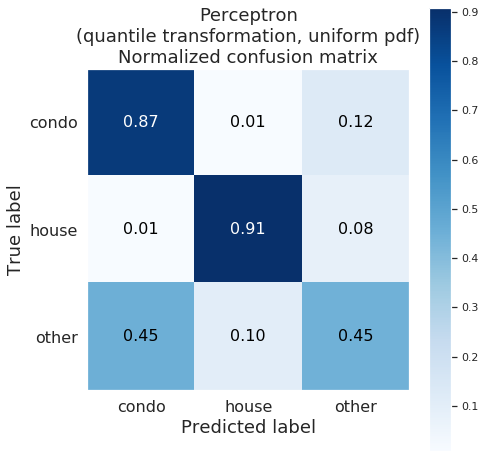

In [189]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, ppn.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

### Logistic regression (L2 regularization)

In [195]:
n_jobs = 8
penalty = 'l2'
c = 0.1
max_iter = 100
model_name = 'Logistic regression\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lr_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='lbfgs', 
                        multi_class='auto', max_iter=max_iter, n_jobs=n_jobs)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 26.98 seconds (0.45 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [196]:
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='lbfgs', 
                        multi_class='auto', max_iter=max_iter, n_jobs=n_jobs)
lr.fit(X_train_qu, y_train)
lr.score(X_test_qu, y_test)

0.764116533002876

In [197]:
cr = classification_report(y_test, lr.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.688756,0.880756,0.709760,0.764117,0.759757,0.762035
recall,0.653871,0.908266,0.714442,0.764117,0.758860,0.764117
f1-score,0.670860,0.894299,0.712094,0.764117,0.759084,0.762883
support,66871.000000,86664.000000,103079.000000,0.764117,256614.000000,256614.000000


Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[0.65 0.01 0.33]
 [0.   0.91 0.09]
 [0.19 0.09 0.71]]


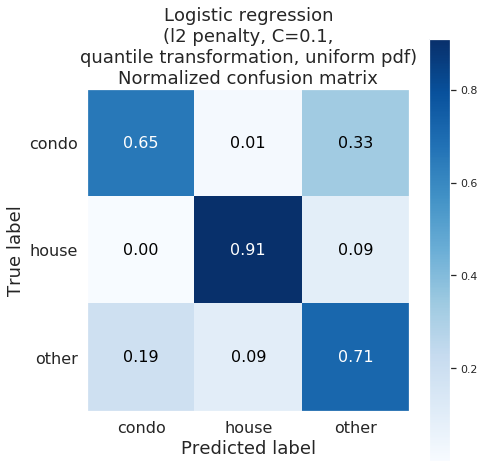

In [198]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

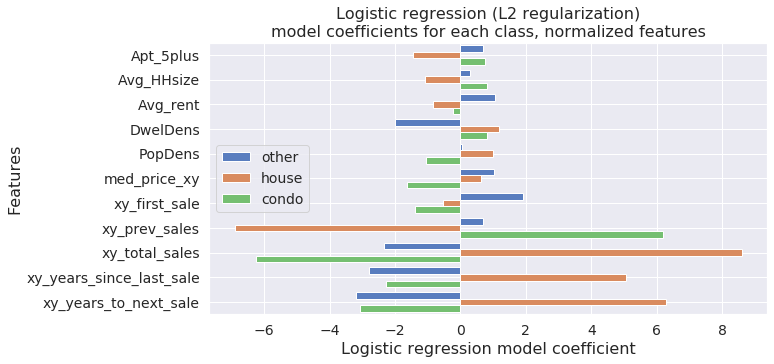

In [199]:
lr_coef = pd.DataFrame()
for cl in range(lr.coef_.shape[0]):
    class_coef = pd.DataFrame(lr.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lr_coef = lr_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L2 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(model_code, feat_set_name), dpi=300, bbox_inches='tight')

### Logistic regression (L1 regularization)

In [200]:
penalty = 'l1'
c = 0.1
max_iter = 100
model_name = 'Logistic regression\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lr_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 187.23 seconds (3.12 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [201]:
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
lr.fit(X_train_qu, y_train)
lr.score(X_test_qu, y_test)

0.7609210721160965

In [202]:
cr = classification_report(y_test, lr.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.688191,0.869661,0.709647,0.760921,0.755833,0.758096
recall,0.651523,0.910332,0.706274,0.760921,0.756043,0.760921
f1-score,0.669355,0.889532,0.707957,0.760921,0.755614,0.759219
support,66871.000000,86664.000000,103079.000000,0.760921,256614.000000,256614.000000


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.52e-01 1.85e-02 3.30e-01]
 [5.42e-04 9.10e-01 8.91e-02]
 [1.91e-01 1.03e-01 7.06e-01]]


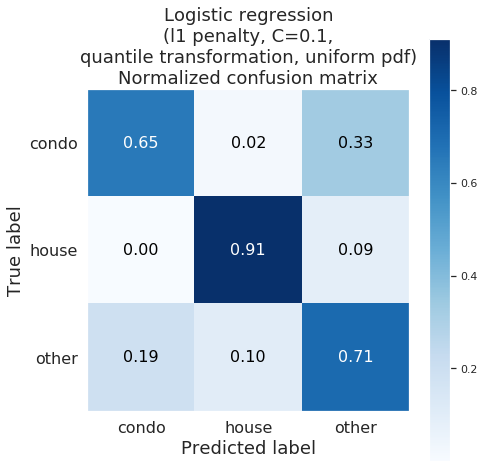

In [203]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

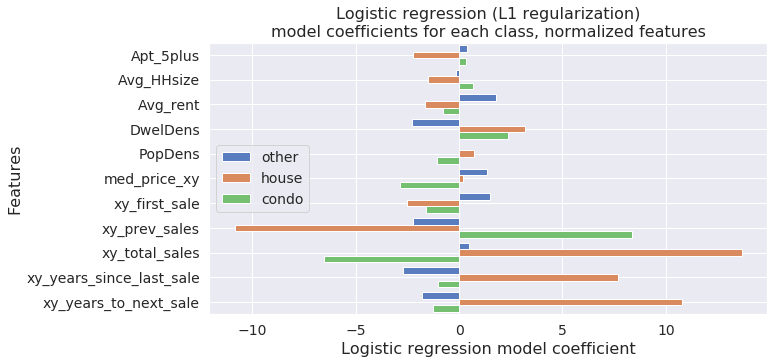

In [209]:
lr_coef = pd.DataFrame()
for cl in range(lr.coef_.shape[0]):
    class_coef = pd.DataFrame(lr.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lr_coef = lr_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L1 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(model_code, feat_set_name), dpi=300, bbox_inches='tight')

### Linear Discriminant Analysis (LDA)

In [205]:
model_name = 'Linear Discriminant Analysis (LDA)'
model_code = 'lda'
lda = LinearDiscriminantAnalysis()
scores_df.loc[scores_name] = \
    fit_model(lda, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Linear Discriminant Analysis (LDA) fit, took 2.43 seconds (0.04 minutes)
accuracy: train=0.73, test=0.73, validation #1=0.70, validation #2=0.71


In [206]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_qu, y_train)
lda.score(X_test_qu, y_test)

0.730517430849447

In [207]:
cr = classification_report(y_test, lda.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Linear Discriminant Analysis (LDA)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.649793,0.821306,0.698212,0.730517,0.723104,0.727166
recall,0.660316,0.891558,0.640664,0.730517,0.730846,0.730517
f1-score,0.655012,0.854991,0.668201,0.730517,0.726068,0.727847
support,66871.000000,86664.000000,103079.000000,0.730517,256614.000000,256614.000000


Linear Discriminant Analysis (LDA)
Normalized confusion matrix
[[6.60e-01 5.31e-02 2.87e-01]
 [2.31e-04 8.92e-01 1.08e-01]
 [2.31e-01 1.29e-01 6.41e-01]]


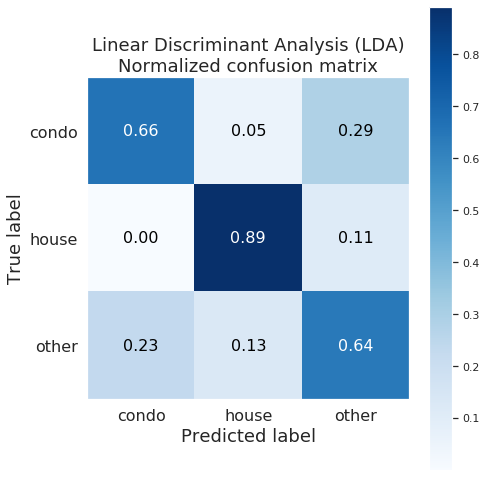

In [208]:
plot_confusion_matrix(y_test, lda.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

### Quadratic Discriminant Analysis (QDA)

In [210]:
model_name = 'Quadratic Discriminant Analysis'
model_code = 'qda'
qda = QuadraticDiscriminantAnalysis()
scores_df.loc[scores_name] = \
    fit_model(qda, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Quadratic Discriminant Analysis fit, took 1.21 seconds (0.02 minutes)
accuracy: train=0.66, test=0.66, validation #1=0.66, validation #2=0.60


In [214]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_qu, y_train)
qda.score(X_test_qu, y_test)

0.656620449390914

In [215]:
cr = classification_report(y_test, qda.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Quadratic Discriminant Analysis


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.509604,0.795852,0.789907,0.65662,0.698454,0.718870
recall,0.946673,0.953372,0.218958,0.65662,0.706334,0.656620
f1-score,0.662550,0.867520,0.342874,0.65662,0.624314,0.603362
support,66871.000000,86664.000000,103079.000000,0.65662,256614.000000,256614.000000


Quadratic Discriminant Analysis
Normalized confusion matrix
[[0.95 0.01 0.05]
 [0.01 0.95 0.03]
 [0.58 0.2  0.22]]


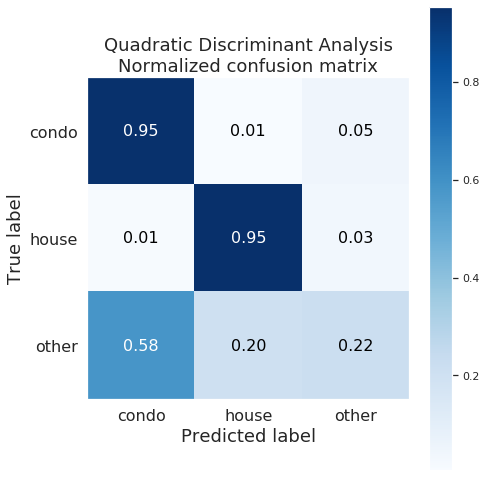

In [216]:
plot_confusion_matrix(y_test, qda.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

### Linear Support Vector Classification (L2)

In [ ]:
penalty = 'l2'
max_iter = 100
c = 1.0
n_jobs = 1
model_name = 'Linear Support Vector Classification'
model_code = 'lsvc_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
model = LinearSVC(random_state=random_state, penalty=penalty, loss='squared_hinge', max_iter=max_iter, C=c)
model_times_scores_df = get_fit_times(model, feat_dict, target_dict, model_name, model_code, n_jobs)
times_scores_df = times_scores_df.append(model_times_scores_df)

In [200]:
penalty = 'l2'
c = 1.0
max_iter = 100
model_name = 'Linear Support Vector Classification'
model_code = 'lsvc_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 187.23 seconds (3.12 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [201]:
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
lr.fit(X_train_qu, y_train)
lr.score(X_test_qu, y_test)

0.7609210721160965

In [202]:
cr = classification_report(y_test, lr.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.688191,0.869661,0.709647,0.760921,0.755833,0.758096
recall,0.651523,0.910332,0.706274,0.760921,0.756043,0.760921
f1-score,0.669355,0.889532,0.707957,0.760921,0.755614,0.759219
support,66871.000000,86664.000000,103079.000000,0.760921,256614.000000,256614.000000


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.52e-01 1.85e-02 3.30e-01]
 [5.42e-04 9.10e-01 8.91e-02]
 [1.91e-01 1.03e-01 7.06e-01]]


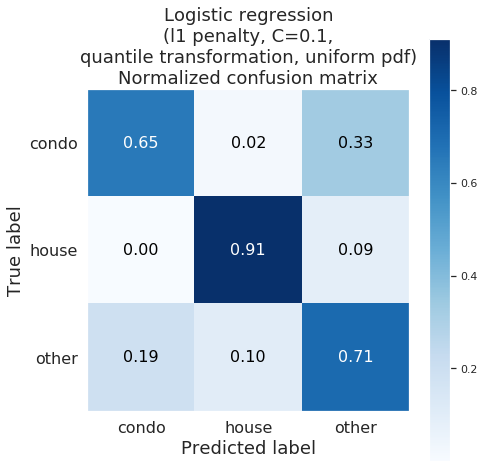

In [203]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

#### Decision Tree

Validation curve for Decision Tree plotted, took 757.80 seconds (12.63 minutes)


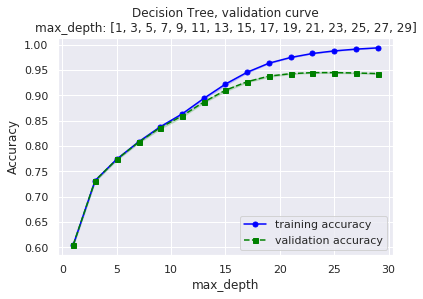

In [42]:
param_name = 'max_depth'
param_range = list(range(1, 30, 2))
model_name = "Decision Tree"
tree = DecisionTreeClassifier(criterion='gini',  random_state=random_state)
plot_validation_curve(tree, model_name, X_train, y_train, param_name, param_range)

##### Best model performance

In [58]:
# set model name and hyperparameters
max_depth = 23
criterion = 'gini'
model_name = 'Decision Tree ({0} criterion, raw features)'.format(criterion)
scores_name = 'tree_raw_{0}_{1}'.format(criterion, max_depth)

# get best model scores
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
scores_df.loc[scores_name] = \
    fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)

# visualize decision tree
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=le.classes_,
                           feature_names=feat_cols, 
                           out_file='../../results/{0}_{1}_features.dot'.format(model_name, feat_set_name))

# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')


Decision Tree (gini criterion, raw features) fit, took 6.66 seconds (0.11 minutes)
accuracy: train=0.98, test=0.95, validation #1=0.89, validation #2=0.84


#### Random Forest

Validation curve for Random Forest plotted, took 3,421.11 seconds (57.02 minutes)


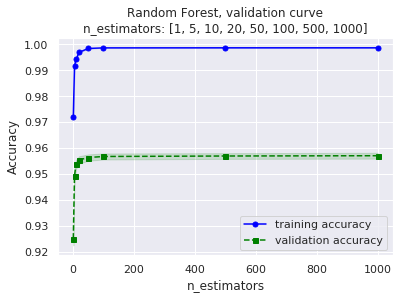

In [45]:
param_name = 'n_estimators'
param_range = [1, 5, 10, 20, 50, 100, 500, 1000]
model_name = "Random Forest"
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=12)
plot_validation_curve(forest, model_name, X_train, y_train, param_name, param_range)

##### Best model performance

In [46]:
# set model name and hyperparameters
n_trees = 16
criterion = 'gini'
scores_name = 'forest_raw_{0}_{1}'.format(criterion, n_trees)

# get best model scores
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=12)
scores_df.loc[scores_name] = \
    fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)


Random Forest fit, took 8.13 seconds (0.14 minutes)
accuracy: train=1.00, test=0.96, validation #1=0.92, validation #2=0.86


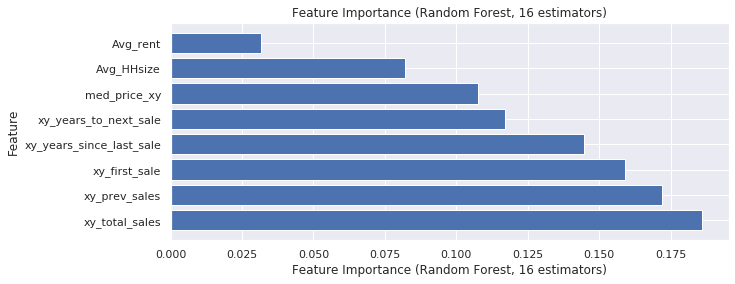

In [47]:
# fit Random Forest model
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_trees)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
forest.score(X_val1, y_val1)

# plot feature importances from Random Forest
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
ax.set_ylabel('Feature')
f.savefig('../../results/plots/rf{0}_'.format(n_trees) + feat_set_name + '_feature_importance.png', dpi=300)

#### K-nearest neighbors

##### Normalized features, Manhattan distance

In [ ]:
p = 1
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model_name = "K-nearest neighbors (normalized  features)"
knn = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=12)
plot_validation_curve(knn, model_name, X_train_norm, y_train, param_name, param_range)

##### Normalized features, Euclidean distance

In [ ]:
p = 2
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model_name = "K-nearest neighbors (normalized  features)"
knn = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=12)
plot_validation_curve(knn, model_name, X_train_norm, y_train, param_name, param_range)

##### Best model performance

In [59]:
k = 5
p = 1
model_name = 'K-nearest neighbors, k={0}, p={1} (normalized  features)'.format(k, p)
scores_name = 'knn_norm_k{0}_p{1}'.format(k, p)

knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
scores_df.loc[scores_name] = \
    fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True)


K-nearest neighbors, k=5, p=1 (normalized  features) fit, took 447.36 seconds (7.46 minutes)
accuracy: train=0.95, test=0.94, validation #1=0.88, validation #2=0.83


## Compare perfomance of models

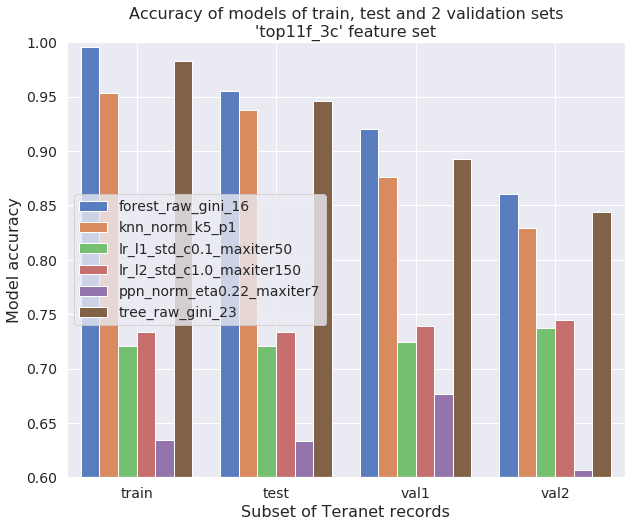

In [60]:
scores_tidy = scores_df.reset_index().rename(columns={'index': 'model'})\
                       .melt(id_vars='model', var_name='subset', value_name='score').sort_values(['model', 'subset'])

f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="subset", y="score", hue="model", order=['train', 'test', 'val1', 'val2'],
                                                       data=scores_tidy, palette="muted", ax=ax)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xlabel("Subset of Teranet records", fontsize=16)
ax.set_title("Accuracy of models of train, test and 2 validation sets\n'{0}' feature set".format(feat_set_name), 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0.6, 1.0)
plt.savefig('../../results/plots/model_performance_' + feat_set_name + '.png'
            .format(model_name), dpi=300, bbox_inches='tight')

## Learning curves

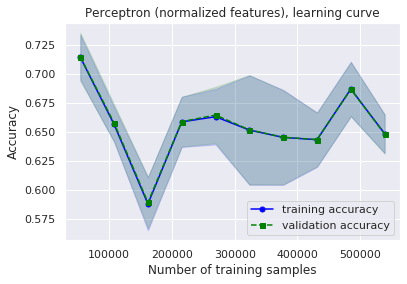

In [61]:
model_name = 'Perceptron (normalized features)'
eta = 0.22
max_iter = 7
ppn = Perceptron(max_iter=max_iter, eta0=eta, random_state=random_state)
plot_learning_curve(ppn, model_name, X_train_norm, y_train, n_jobs=12)

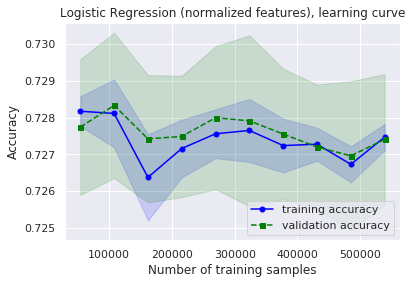

In [62]:
model_name = 'Logistic Regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=random_state, solver='lbfgs', multi_class='auto', max_iter=150, n_jobs=12)
plot_learning_curve(lr, model_name, X_train_norm, y_train)

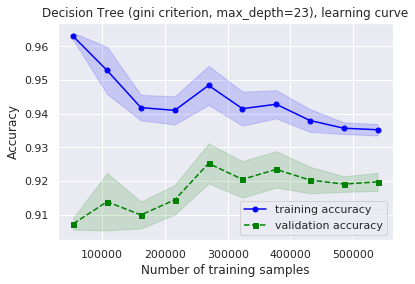

In [63]:
model_name = 'Decision Tree ({0} criterion, max_depth={1})'.format(criterion, max_depth)
max_depth = 16
criterion = 'gini'
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
plot_learning_curve(tree, model_name, X_train, y_train)

## Predict `lucr` using the best performing model

In [64]:
# set model name and hyperparameters
n_trees = 16
criterion = 'gini'
model_name = "Random Forest, n_estimators={0}".format(n_trees)
predict_col_name = 'lucr_predict_forest_{0}_{1}'.format(criterion, n_trees)


t = time()
# predict lucr using best performing model
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
s[predict_col_name] = forest.predict(X)
s_val1[predict_col_name] = forest.predict(X_val1)
s_val2[predict_col_name] = forest.predict(X_val2)

elapsed = time() - t
print("lucr predicted, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

lucr predicted, took 7.64 seconds (0.13 minutes)


13,680 misclassified entries in the subset, or 1.60% of the total 855,378.


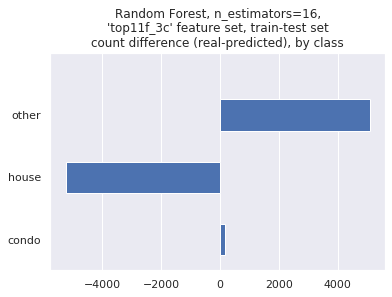

In [65]:
plot_pred_dif(s, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='train-test set', labels=le.classes_)

17,263 misclassified entries in the subset, or 2.02% of the total 216,155.


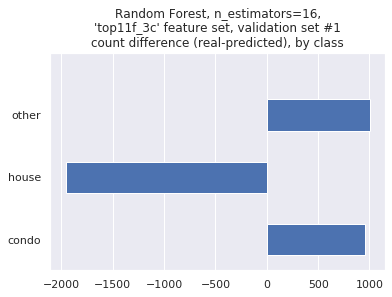

In [66]:
plot_pred_dif(s_val1, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='validation set #1', labels=le.classes_)

34,188 misclassified entries in the subset, or 4.00% of the total 244,425.


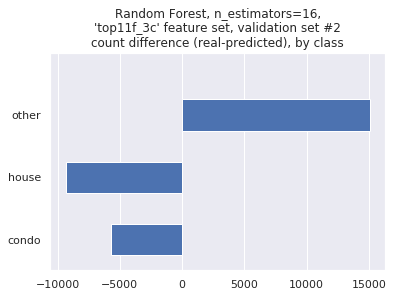

In [67]:
plot_pred_dif(s_val2, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='validation set #2', labels=le.classes_)

## Confusion matrix